In [1]:
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
def get_non_uniform_sampling(source, steps):
    shape = np.shape(source)
    height = shape[0]
    length = shape[1]
    
    x_centre = int(length/2)
    y_centre = int(height/2)
    radius = int(min(length, height)/2)
    
    pi = np.pi
    multiplier = 0.5
    x_coordinates = []
    y_coordinates = []

    for r in steps:
        number_of_points = (1/multiplier) * 2

        for j in range(int(number_of_points)):
            theta = j*pi*multiplier
            x = x_centre + (r * np.cos(theta))
            y = y_centre + (r * np.sin(theta))
            
            if(x<length and x>0 and y<height and y>0):
                x_coordinates.append(int(x))
                y_coordinates.append(int(y))

        multiplier = multiplier/2
    
    return x_coordinates, y_coordinates

def get_roi_values(src, x , y, window_size):
    height = np.shape(img)[0]
    length = np.shape(img)[1]
    
    left = x - int(window_size/2)
    left = max(0, left)
    
    right = x + int(window_size/2)
    right = min(length, right)
    
    top = y - int(window_size/2)
    top = max(0, top)
    
    bottom = y + int(window_size/2)
    bottom = min(height, bottom)
    
    slice_arr = src[top:bottom, left:right]
    
    return slice_arr, np.mean(slice_arr), np.std(slice_arr)

def get_mean_std(src, x_coordinates, y_coordinates, window_size):
    mean = []
    std = []
    number_of_points = np.shape(x_coordinates)[0]
    
    for i in range(number_of_points):
        slice_arr, slice_mean, slice_std = get_roi_values(src, x_coordinates[i], y_coordinates[i], window_size)
        mean.append(slice_mean)
        std.append(slice_std)
    
    return mean, std

In [3]:
img = cv2.imread("./Images/OS0049EY.JPG")
print(np.shape(img))
(B,G,R) = cv2.split(img)
#cv2.imshow("Source Image", B)
#cv2.waitKey(0)

(1248, 1664, 3)


In [4]:
steps = [40, 150, 330, 500, 610]
x_coordinates, y_coordinates = get_non_uniform_sampling(G, steps)
number_of_points = (np.shape(x_coordinates))[0]
print("The number of points is", number_of_points)

The number of points is 124


In [5]:
# x_edge = [751,  705,  998, 1043,  576, 1120, 1158,  467,  435, 1256,  379,
#        1312,  325,  301,  278,  257,  235, 1447,  196, 1486, 1503, 1517,
#        1527, 1536,  119, 1547,  116,  114,  114, 1552, 1547, 1543, 1539,
#        1533,  135, 1514, 1498,  183, 1461, 1441, 1420,  263,  285,  309,
#         332,  359,  385, 1248, 1220, 1186,   49,  519,   12, 1117,   44,
#          17, 1065]
# y_edge = [   0,    6,   14,   24,   37,   50,   66,   84,  102,  120,  139,
#         159,  181,  203,  226,  251,  277,  305,  337,  371,  407,  444,
#         478,  507,  536,  562,  588,  617,  639,  661,  690,  719,  745,
#         773,  801,  838,  875,  912,  945,  975, 1003, 1029, 1053, 1075,
#        1097, 1118, 1139, 1157, 1175, 1193, 1208, 1213, 1219, 1224, 1230,
#        1235, 1242]

In [6]:
# x_coordinates = np.array([x_coordinates, x_edge])
# y_coordinates.append(y_edge)

Text(0.5, 1.0, 'Image and Sampling Points')

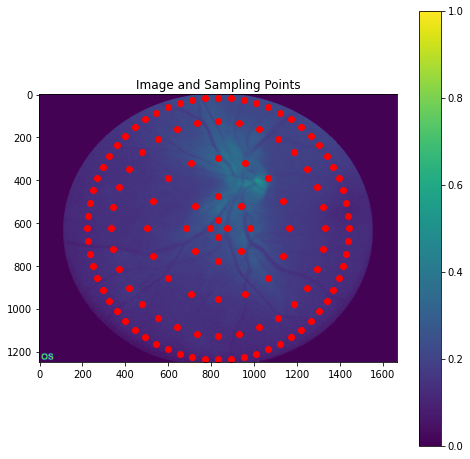

In [7]:
plt.figure(figsize = (8,8))
plt.imshow(G)
plt.scatter(x_coordinates, y_coordinates, color='red')
plt.colorbar()
plt.title("Image and Sampling Points")

In [8]:
mean, std = get_mean_std(G, x_coordinates, y_coordinates, 50)

In [9]:
xi = np.arange(0, np.shape(G)[1], 1)
yi = np.arange(0, np.shape(G)[0], 1)
x_grid, y_grid = np.meshgrid(xi, yi)

points = []
for i , j in zip(x_coordinates, y_coordinates):
    points.append([i,j])

Text(0.5, 1.0, 'Interpolated Mean')

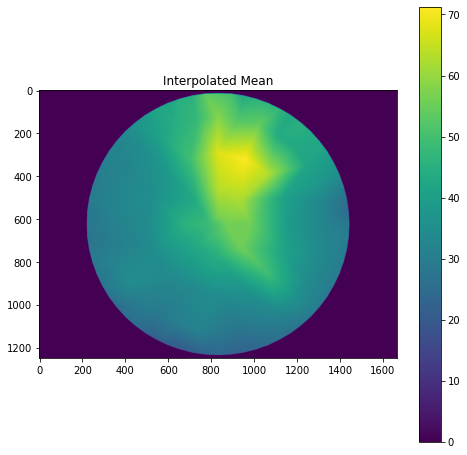

In [10]:
interpolated_mean = scipy.interpolate.griddata(points, mean, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_mean)
plt.colorbar()
plt.title("Interpolated Mean")

Text(0.5, 1.0, 'Interpolated Standard Deviation')

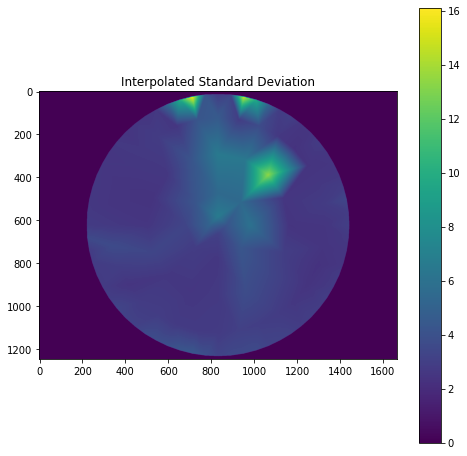

In [11]:
interpolated_std = scipy.interpolate.griddata(points, std, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_std)
plt.colorbar()
plt.title("Interpolated Standard Deviation")

C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/589023850.py:11: RuntimeWarning: divide by zero encountered in true_divide
  mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/589023850.py:11: RuntimeWarning: invalid value encountered in true_divide
  mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)


Text(0.5, 1.0, 'Mahalanobis Distance')

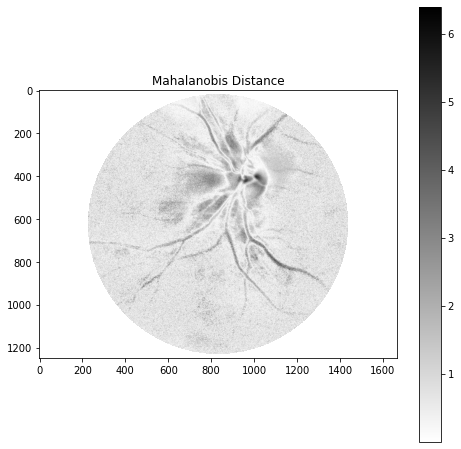

In [12]:
height = np.shape(G)[0]
length = np.shape(G)[1]

mahalanobis = np.empty(np.shape(G))
background = np.zeros(np.shape(G))

G = np.array(G)
interpolated_mean = np.array(interpolated_mean)
interpolated_std = np.array(interpolated_std)

mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
plt.figure(figsize = (8,8))
plt.imshow(mahalanobis, cmap='binary')
plt.colorbar()
plt.title("Mahalanobis Distance")

Text(0.5, 1.0, 'Background')

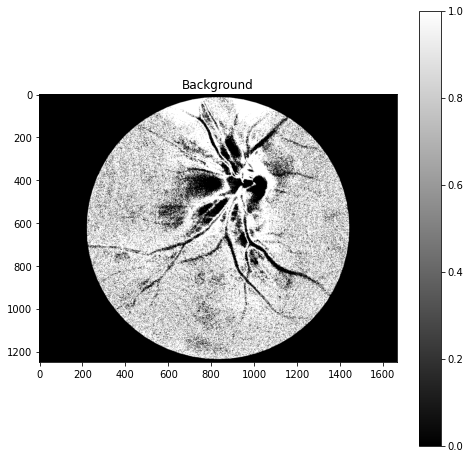

In [13]:
threshold = 1.25
indexes = np.where(mahalanobis <= threshold)
background = np.zeros([height, length], dtype=int)
background[indexes] = 1

plt.figure(figsize = (8,8))
plt.imshow(background, cmap="binary_r")
plt.colorbar()
plt.title("Background")

Text(0.5, 1.0, 'Mult')

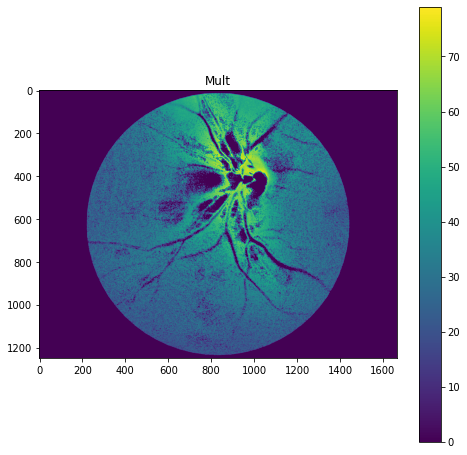

In [14]:
background = np.array(background)
G = np.array(G)
mult = background*G

# mult = mult.astype(np.uint8)
# plt.figure(figsize = (8,8))
# plt.imshow(mult)
# plt.colorbar()
# plt.title("Mult")

In [15]:
mean_mult = []
std_mult = []
background_window_size = 125
  
for i in range(length):
    for j in range(height):
        mult_slice, temp_mean, temp_std = get_roi_values(mult, i , j, background_window_size)
        mult_slice = mult_slice[(mult_slice != 0)]
        if(not np.any(mult_slice)):
            mean_mult.append(0) 
            std_mult.append(0)
        else:
            mean_m = np.mean(mult_slice)
            std_m = np.std(mult_slice)
            mean_mult.append(mean_m)
            std_mult.append(std_m)

In [16]:
U = np.empty(np.shape(G))
SM = np.array(mean_mult)
SA = np.array(std_mult)
SM = SM.reshape(height, length,  order='F')
SA = SA.reshape(height, length, order='F')
U = (G - SM) / SA

C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/4276762874.py:6: RuntimeWarning: divide by zero encountered in true_divide
  U = (G - SM) / SA
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/4276762874.py:6: RuntimeWarning: invalid value encountered in true_divide
  U = (G - SM) / SA


In [17]:
U[np.isnan(U)] = 0
U[~np.isfinite(U)] = 0
U_norm = (U - np.min(U))/(np.max(U)- np.min(U))

# plt.figure(figsize = (8,8))
# plt.imshow(U_norm)
# plt.colorbar()
# plt.title("U norm")

Text(0.5, 1.0, 'SM')

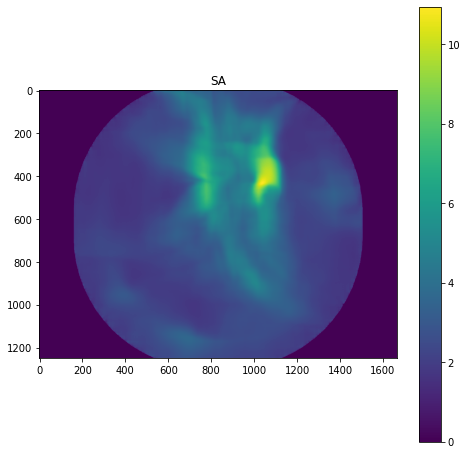

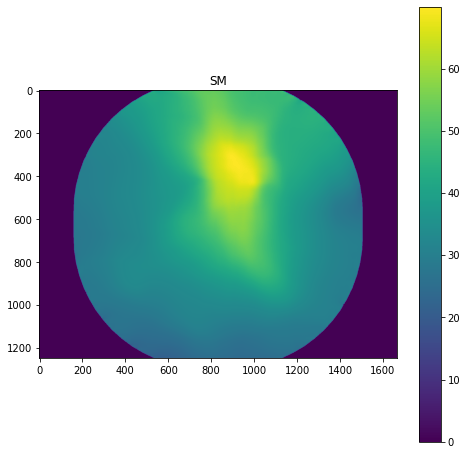

In [18]:
plt.figure(figsize = (8,8))
plt.imshow(SA)
plt.colorbar()
plt.title("SA")

plt.figure(figsize = (8,8))
plt.imshow(SM)
plt.colorbar()
plt.title("SM")

C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/1945895660.py:7: RuntimeWarning: divide by zero encountered in true_divide
  R_corr = (U_norm/v)*R
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/1945895660.py:7: RuntimeWarning: invalid value encountered in multiply
  R_corr = (U_norm/v)*R
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/1945895660.py:8: RuntimeWarning: divide by zero encountered in true_divide
  G_corr = (U_norm/v)*G
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/1945895660.py:8: RuntimeWarning: invalid value encountered in multiply
  G_corr = (U_norm/v)*G
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/1945895660.py:9: RuntimeWarning: divide by zero encountered in true_divide
  B_corr = (U_norm/v)*B
C:\Users\aniru\AppData\Local\Temp/ipykernel_9300/1945895660.py:9: RuntimeWarning: invalid value encountered in multiply
  B_corr = (U_norm/v)*B


Text(0.5, 1.0, 'Corrected B plane')

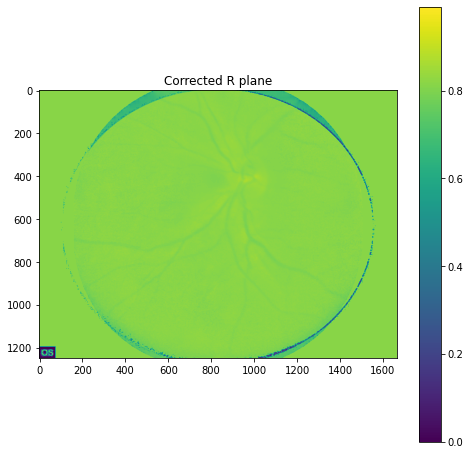

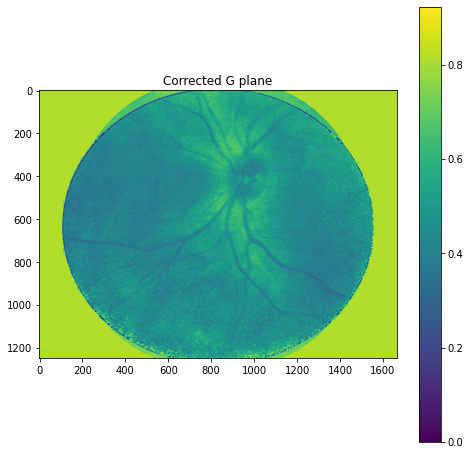

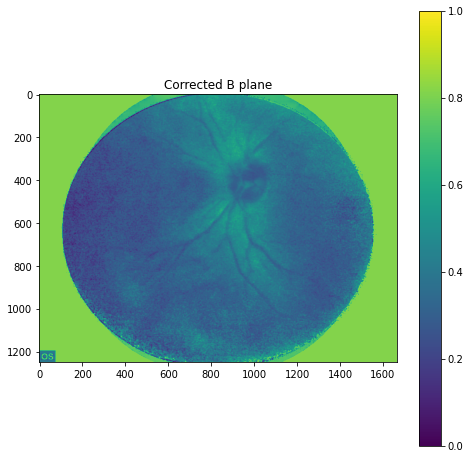

In [19]:
v = np.empty(np.shape(G))
R = np.array(R)
G = np.array(G)
B = np.array(B)

v = np.maximum(np.maximum(R,G),B)
R_corr = (U_norm/v)*R
G_corr = (U_norm/v)*G
B_corr = (U_norm/v)*B

R_corr[np.isnan(R_corr)] = 0
G_corr[np.isnan(G_corr)] = 0
B_corr[np.isnan(B_corr)] = 0

plt.figure(figsize = (8,8))
plt.imshow(R_corr)
plt.colorbar()
plt.title("Corrected R plane")

plt.figure(figsize = (8,8))
plt.imshow(G_corr)
plt.colorbar()
plt.title("Corrected G plane")

plt.figure(figsize = (8,8))
plt.imshow(B_corr)
plt.colorbar()
plt.title("Corrected B plane")

In [20]:
enhanced_image = cv2.merge([B_corr, G_corr, R_corr])

In [21]:
cv2.namedWindow('Enhanced Image', cv2.WINDOW_NORMAL)
cv2.imshow("Enhanced Image", enhanced_image)
cv2.waitKey(0)

-1